# Differential Evolution (DE)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Example: minimize an objective function

### 1. Objective function

We'll define the objective function that we want to optimize. For this example, let's use the Rosenbrock function as example:

$f(x, y) = (1 - x)^2 + 100(y - x^2)^2$

In [70]:
def objective_function(x):
    # Rosenbrock function
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

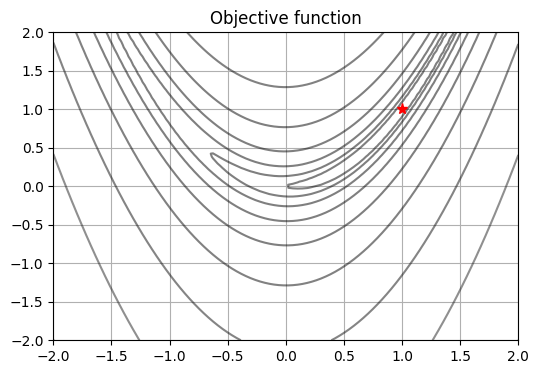

In [115]:
plt.figure(figsize=(6, 4))

# Define the range for x and y coordinates
Xfun = np.linspace(-2, 2, 100)
Yfun = np.linspace(-2, 2, 100)

# Create a grid of x and y values
mesh = np.meshgrid(Xfun, Yfun)

# Calculate the Rosenbrock function values for each point in the grid
Zfun = objective_function(mesh)

# Create a contour plot of the Rosenbrock function
plt.contour(Xfun, Yfun, Zfun, levels=np.logspace(0, 4, 10), cmap='gray', alpha=0.5)
plt.plot(1, 1, '*', color='red', markersize=8)
plt.title('Objective function')
plt.grid(True)
plt.show()

### 2. Initialize the population

Let's set up our initial population of size $N_p$ and generate random vectors $\vec x_i$ within a given search space with $i = 1, 2, ..., N_p$.

In [305]:
# Define the search space bounds
lower_bound = -2
upper_bound = 2

# Population size
Np = 8

# Initialize the population with random solutions
population = np.random.uniform(lower_bound, upper_bound, [Np,2])

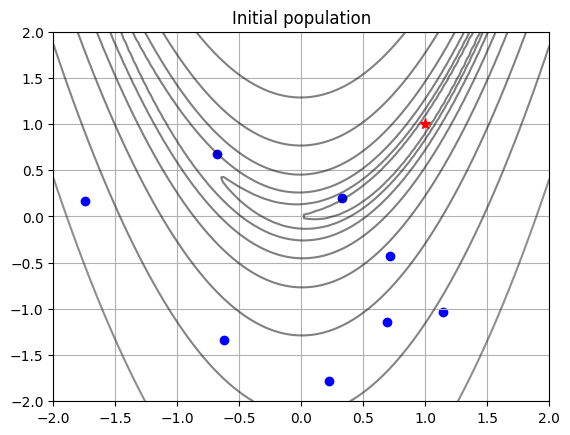

In [306]:
plt.contour(Xfun, Yfun, Zfun, levels=np.logspace(0, 4, 10), cmap='gray', alpha=0.5)
plt.scatter(population.T[0], population.T[1], marker='o', color='blue')
plt.plot(1, 1, '*', color='red', markersize=8)
plt.title('Initial population')
plt.grid(True)
plt.show()

### 3. Evaluate the population

Now, we'll evaluate the fitness of each solution in the population using our objective function, this is, $f(\vec x_i)$ for $i=1,2,.., N_p$.

In [307]:
# Evaluate the fitness of each solution
fitness = objective_function(population.T)

In [308]:
pd.DataFrame(population)

,0,1
0,-0.680077,0.677810
1,0.714890,-0.423645
2,1.138473,-1.029594
3,0.691407,-1.140590
4,0.324439,0.201175
5,0.221327,-1.778540
6,-1.743207,0.166431
7,-0.622661,-1.333194


In [309]:
pd.DataFrame(fitness)

,0
0,7.458274
1,87.450133
2,540.914157
3,262.092694
4,1.376341
5,334.591134
6,832.558455
7,298.782965


### 4. Optimization loop

The core of DE lies in its optimization loop. But first, let's take a look at what's into the loop, one iteration at a time.

#### 4.1. Mutation

For each $\vec x_i$ with $i=1,2,...,N_p$, a mutant vector is generated according to next strategies:
- **DE/rand/1**: $\vec v_i = \vec x_{r1} + F (\vec x_{r2} - \vec x_{r3})$
- **DE/best/1**: $\vec v_i = \vec x_{\text{best}} + F (\vec x_{r1} - \vec x_{r2})$
- **DE/rand/2**: $\vec v_i = \vec x_{r1} + F (\vec x_{r2} - \vec x_{r3}) + F (\vec x_{r4} - \vec x_{r5})$
- **DE/best/2**: $\vec v_i = \vec x_{\text{best}} + F (\vec x_{r1} - \vec x_{r2}) + F (\vec x_{r3} - \vec x_{r4})$
- **DE/current-to-best/1**: $\vec v_i = \vec x_i + F(\vec x_{\text{best}} - \vec x_i) + F (\vec x_{r1} - \vec x_{r2})$

Where $r1, r2, r3, r4, r5 \in \{ 1,2,...,N_p\}$ are random indices different from each other and different from $i$. $F$ (mutation factor) is a real and constant factor $\in [0,2]$ which controls the amplification of the differential variation.
Let's use the simplest: **DE/rand/1**

In [310]:
i = 0

# Create the indices population without index i
indices = np.delete(np.arange(Np), [i])

# Select three distinct indices
r_indeces = np.random.choice(indices, size=3, replace=False)

# Extract the three random vectors from the population
random_vecs = population[r_indeces]

# Create a mutant vector
F = 0.5 # Mutation factor
mutant = random_vecs[0] + F * (random_vecs[1] - random_vecs[2]) # DE/rand/1

# Ensure the values of mutant are within the search space
mutant = np.clip(mutant, lower_bound, upper_bound)

#### 4.2. Crossover

In order to increase the diversity of the perturbed parameter vectors, crossover is introduced. To this end, the trial vector is formed following:

\begin{equation}
u_{i,j} = 
\begin{cases} 
v_{i,j} & \text{if } r_{i,j} \leq C_r \text{ or } j = j_{\text{rand}} \\
x_{i,j} & \text{otherwise}
\end{cases}
\end{equation}

where $r_{i,j} \in [0,1]$ is a random number, $C_r$ is the crossover probability, $j=1,2,...,D$ is the component of the $D$-dimensional vector (in this example $D=2$), and $j_\text{rand} \in [0,D]$ is a random number.

In [311]:
# Perform crossover to create a trial solution
D = 2
Cr = 0.7
crossover_mask = np.random.rand(D) < Cr
if crossover_mask.sum() == 0:
    crossover_mask[np.random.randint(D)] = True
trial = np.where(crossover_mask, mutant, population[i])

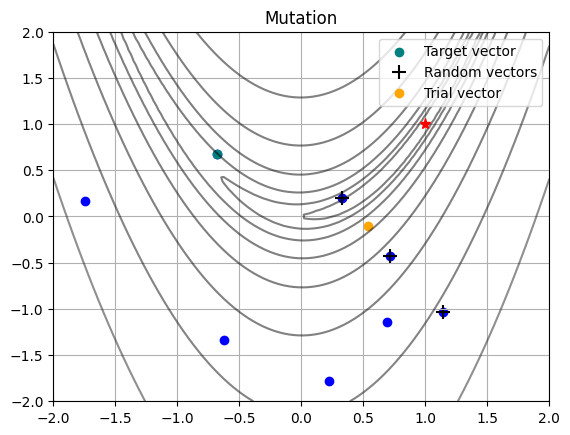

In [312]:
plt.contour(Xfun, Yfun, Zfun, levels=np.logspace(0, 4, 10), cmap='gray', alpha=0.5)
plt.scatter(population.T[0], population.T[1], marker='o', color='blue')
plt.scatter(population.T[0][i], population.T[1][i], marker='o', color='teal', label='Target vector')
plt.scatter(random_vecs.T[0], random_vecs.T[1], marker='+', color='k', s=100, label='Random vectors')
plt.scatter(trial[0], trial[1], marker='o', color='orange', label='Trial vector')
plt.plot(1, 1, '*', color='red', markersize=8)
plt.title('Mutation')
plt.legend()
plt.grid(True)
plt.show()

#### 4.3. Selection

To decide whether or not trial vector should become a member of next generation, we use the next criterion:

\begin{equation}
\vec x_{i}^{\text{new}} = 
\begin{cases} 
\vec u_{i} & \text{if } f(\vec u_{i}) < f(\vec x_{i}) \\
\vec x_{i} & \text{otherwise}
\end{cases}
\end{equation}


In [313]:
# Evaluate the fitness of the trial vector
trial_fitness = objective_function(trial)
        
# Update the population if the trial vector is better
if trial_fitness < fitness[i]:
    population[i] = trial
    fitness[i] = trial_fitness
    print('Accepted')
else:
    print('Not accepted')

Not accepted


### 5. Main

In [394]:
# Define the search space bounds
lower_bound = -2
upper_bound = 2

# Differential Evolution parameters
D = 2
Np = 8
F = 0.5
Cr = 0.7

# Initialize the population with random solutions
population = np.random.uniform(lower_bound, upper_bound, [Np,2])

# Evaluate the fitness of each solution
fitness = objective_function(population.T)

In [407]:
# Main optimization loop
num_generations = 1  # You can adjust this as needed

for generation in range(num_generations):
    for i in range(Np):
        # Create the indices population without index i
        indices = np.delete(np.arange(Np), [i])
        
        # Select three distinct indices
        r_indeces = np.random.choice(indices, size=3, replace=False)
        
        # Extract the three random vectors from the population
        random_vecs = population[r_indeces]
        
        # Create a mutant vector
        F = 0.5 # Mutation factor
        mutant = random_vecs[0] + F * (random_vecs[1] - random_vecs[2]) # DE/rand/1
        
        # Ensure the values of mutant are within the search space
        mutant = np.clip(mutant, lower_bound, upper_bound)
        
        # Perform crossover to create a trial solution
        crossover_mask = np.random.rand(D) < Cr
        if crossover_mask.sum() == 0:
            crossover_mask[np.random.randint(D)] = True
        trial = np.where(crossover_mask, mutant, population[i])
        
        # Evaluate the fitness of the trial vector
        trial_fitness = objective_function(trial)
                
        # Update the population if the trial vector is better
        if trial_fitness < fitness[i]:
            population[i] = trial
            fitness[i] = trial_fitness

Best result: [-0.03573963  0.00782888]; Z = 1.0770488829080165


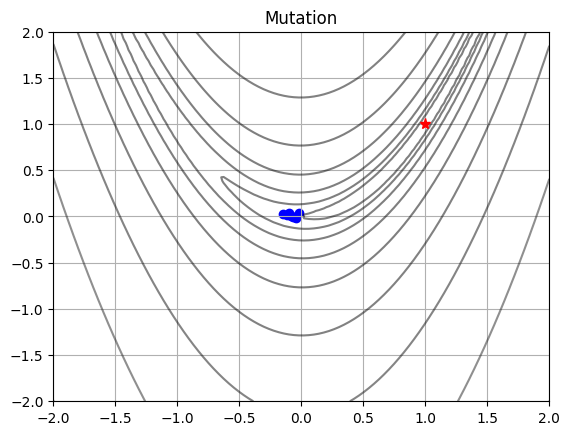

In [406]:
plt.contour(Xfun, Yfun, Zfun, levels=np.logspace(0, 4, 10), cmap='gray', alpha=0.5)
plt.scatter(population.T[0], population.T[1], marker='o', color='blue')
plt.plot(1, 1, '*', color='red', markersize=8)
plt.title('Mutation')
plt.grid(True)
plt.show()

Select the best result:

In [408]:
id = np.argmin(fitness)
print(f"Best result: {population[id]}; Z = {fitness[id]}")

Best result: [-0.03573963  0.00782888]; Z = 1.0770488829080165
